In [1]:
%matplotlib inline
from scipy.stats import ttest_ind

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import numpy as np

from sctools import score


mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(1902834)

Global seed set to 0


In [2]:
genes = pd.read_csv(
    '../resource/fragility_score_genes.txt',
    sep = '\t'
)
genes

,gene,type
0,CCL4,cytokine_chemokine
1,CCL5,cytokine_chemokine
2,CSF2,cytokine_chemokine
3,IFNG,cytokine_chemokine
4,IL13,cytokine_chemokine
5,IL17A,cytokine_chemokine
6,IL2,cytokine_chemokine
7,IL22,cytokine_chemokine
8,IL6,cytokine_chemokine
9,IL9,cytokine_chemokine


In [3]:
adata = sc.read_h5ad(
    '../data/tregs.tissue.scps.integrated.annotated.h5ad'
)
adata

AnnData object with n_obs × n_vars = 9773 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 'dataset', 'sat1_status', 'clustering', 'sat1_status_majority_vote'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [26]:
genes_in_data = set(adata.var.index)
gene_set = set(genes.gene)
', '.join(genes_in_data & gene_set)

'CXCR3, LGALS1, CCR5, IL13, CD27, CD69, CXCR6, ITGAE, IL7R, IFNG, HIF1A, STAT3, IL22, CCL5, CSF2, CCL4, ICOS, GAPDH, CD58, IL2, IL17A, TBX21, CCR2, KLRG1, CD28, RORC, RORA, BATF, PDCD1, IL6, MTOR'

In [4]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [5]:
score_df = pd.DataFrame(
    {
        'fragility_score': score.gene_module_score(adata, genes.gene),
        'sat1_status': adata.obs.sat1_status_majority_vote,
        'sat1_expression': adata[:, 'SAT1'].X.toarray().flatten()
    },
    index = adata.obs.index
)
score_df

,fragility_score,sat1_status,sat1_expression
AAAGATGAGGACAGCT-2,0.273901,SAT1_hi,0.000000
AACTCTTCATGCAATC-2,0.359290,SAT1_hi,0.000000
AAGACCTTCAACGGCC-2,0.252627,SAT1_lo,0.000000
AAGGAGCTCAGCGACC-2,0.168688,SAT1_lo,1.803522
AATCCAGGTTGGTTTG-2,0.080132,SAT1_lo,0.000000
...,...,...,...
TCAATCTTCCGTGTGG-167,0.155130,SAT1_lo,0.000000
TCACTCGAGCTGAGCA-167,0.056100,SAT1_hi,2.725140
TCATGGAGTCCTTAAG-167,0.239292,SAT1_hi,3.615320
TCGCAGGAGTGAGTTA-167,0.250687,SAT1_lo,3.303417


In [9]:
def subsample_dataframe(df, groupby, n_samples_per_group):
    subsampled_frames = []
    for _, group in df.groupby(groupby):
        sample = np.random.choice(
            group.index,
            size = n_samples_per_group,
            replace = False
        )
        subsampled_frames.append(
            group.loc[sample, :]
        )
    
    return pd.concat(subsampled_frames)


sampled_scores = subsample_dataframe(
    score_df,
    'sat1_status',
    100
)
sampled_scores

,fragility_score,sat1_status,sat1_expression
TAACACGAGAGGCGTT-18,0.344682,SAT1_hi,2.951954
AAAGTAGAGGAGTTGC-91,0.124553,SAT1_hi,0.000000
CCGGGATCATGTCTCC-77,0.279459,SAT1_hi,1.523744
ACTTTCATCGCATGAT-83,0.031192,SAT1_hi,2.359117
TGGCGCAGTCGCGGTT-95,0.115553,SAT1_hi,1.589578
...,...,...,...
CAGCGTGCACAATCTG-110,0.155504,SAT1_lo,1.482703
AACCCAACATGACCCG-113,0.186399,SAT1_lo,3.151791
TAGGCATTCTAGAGTC-65,-0.002542,SAT1_lo,0.000000
GTCACGGTCAGAGTGG-139,-0.029784,SAT1_lo,0.000000


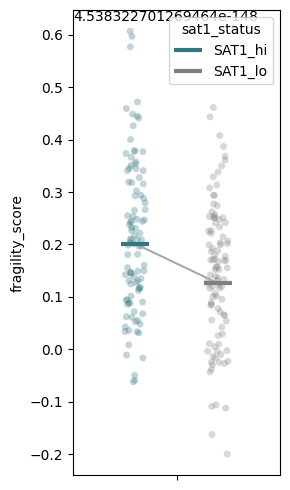

In [24]:
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


fig, ax = plt.subplots()

palette = {
    'SAT1_hi': '#337781',
    'SAT1_lo': '#7f7f7f'
}
sns.stripplot(
    data = sampled_scores, 
    y = 'fragility_score', 
    hue = 'sat1_status',
    dodge = True, 
    alpha = .3, 
    legend = False,
    ax = ax,
    zorder = 1,
    palette = palette
)

marker_dodge = 0.4
sns.pointplot(
    data = score_df, 
    y = 'fragility_score', 
    hue = 'sat1_status', 
    estimator = 'median',
    dodge = marker_dodge, 
    linestyle = 'none', 
    errorbar = None,
    marker = '_', 
    markersize = 20, 
    markeredgewidth = 3,
    ax = ax,
    zorder = 3,
    palette = palette
)

sat1_hi_scores = score_df.loc[score_df.sat1_status == 'SAT1_hi', :]
sat1_lo_scores = score_df.loc[score_df.sat1_status == 'SAT1_lo', :]
sat1_hi_mean = sat1_hi_scores['fragility_score'].median()
sat1_lo_mean = sat1_lo_scores['fragility_score'].median()
ax.plot(
    [-marker_dodge / 2, marker_dodge / 2],
    [sat1_hi_mean, sat1_lo_mean],
    c = 'darkgrey',
    zorder = 2
)

ax.set_xlim(-0.5, 0.5)
ttest_results = ttest_ind(
    sat1_hi_scores['fragility_score'],  
    sat1_lo_scores['fragility_score']
)
_, ymax = ax.get_ylim()
xmin, _ = ax.get_xlim()
ax.text(
    xmin, ymax,
    str(ttest_results.pvalue),
    va = 'top'
)

fig.set_figheight(5)
fig.set_figwidth(3)
fig.tight_layout()
fig.savefig('../plots/tregs.tissue.scps.sat1.fragility.pdf')